In [1]:
import pandas as pd
import re
import yaml
import sqlparse
import os
import pandas as pd
import requests
from IPython.display import display, Markdown


In [2]:
def add_repo_root_path():
    import os
    import sys
    repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if repo_root not in sys.path:
        sys.path.append(repo_root)
        
add_repo_root_path()
from src import generate_knowledge

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', 10) 

## Read dbs

In [4]:
local_dbt_repo = ''
online_dbt_repo = 'https://github.com/dbt-labs/jaffle-shop'

# Use local repo?
if False:
    repo_path = local_dbt_repo
else:
    repo_path = online_dbt_repo

is_online = generate_knowledge.is_online_repo(repo_path)
_, repo_name = generate_knowledge.extract_owner_and_repo(repo_path)
print(repo_name)

jaffle-shop


In [5]:
dbt_models_df = pd.read_csv('../data/dbt_models_' + repo_name + '.csv')
dbt_project_df = pd.read_csv('../data/dbt_project_' + repo_name + '.csv')
display(dbt_models_df.sample(3))
display(dbt_project_df.sample(3))

,path,name,extension,sql_code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description
8,models/marts/metricflow_time_spine.sql,metricflow_time_spine.sql,.sql,-- metricflow_time_spine.sql\nWITH days AS (--...,NaN,NaN,False,False,other,metricflow_time_spine,NaN,NaN,False,NaN,True,False,NaN,NaN,False,['dbt_date.get_base_dates'],True,[],False,NaN,[],True,"""Generates a date range spanning 10 years by c...",NaN
5,models/staging/stg_supplies.sql,stg_supplies.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,supplies,"{'models': [{'name': 'stg_supplies', 'descript...","{'columns': {'supply_uuid': ['not_null', 'uniq...",True,"['product_id', 'supply_id']",True,False,supply_uuid,NaN,False,"['cents_to_dollars', 'dbt_utils.generate_surro...",True,[],True,['ecom.raw_supplies'],"['order_items', 'supplies']",False,Retrieves supply expense data from the 'raw_su...,NaN
1,models/staging/stg_locations.sql,stg_locations.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,locations,"{'models': [{'name': 'stg_locations', 'descrip...","{'columns': {'location_id': ['not_null', 'uniq...",True,['location_id'],True,False,location_id,NaN,False,['dbt.date_trunc'],True,[],True,['ecom.raw_stores'],['locations'],False,"""Extracts a list of open store locations from ...",NaN


,path,name,extension,code,is_seed,is_macro,is_test,packages,description
9,jaffle-data/raw_products.csv,raw_products.csv,.csv,sku name type price ...,False,False,False,NaN,NaN
7,jaffle-data/raw_items.csv,raw_items.csv,.csv,id ...,False,False,False,NaN,NaN
11,jaffle-data/raw_supplies.csv,raw_supplies.csv,.csv,id name cost per...,False,False,False,NaN,NaN


In [6]:
def merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df):
    dbt_models_df['knowledge_type'] = 'models'
    dbt_project_df['knowledge_type'] = 'project'

    dbt_models_df.rename(columns = {'sql_code':'code'}, inplace = True)

    all_columns = set(dbt_models_df.columns).union(set(dbt_project_df.columns))

    for col in all_columns:
        if col not in dbt_models_df:
            dbt_models_df[col] = None
        if col not in dbt_project_df:
            dbt_project_df[col] = None

    merged_df = pd.concat([dbt_models_df, dbt_project_df], ignore_index=True)
    columns_order = ['knowledge_type'] + [col for col in merged_df.columns if col != 'knowledge_type']
    return merged_df[columns_order]

In [7]:
dbt_repo_knowledge_df = merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df)

## LangChain

#### Embeddings and Documents db

In [8]:
def combine_contextual_fields(row):
    combined = f"""        
        Code:
        {row['code'] if pd.notna(row['code']) else 'N/A'}

        Primary Key:
        {row['primary_key'] if pd.notna(row['primary_key']) else 'N/A'}

        IDS:
        {row['sql_ids'] if pd.notna(row['sql_ids']) else 'N/A'}

        Columns used to Filter the model throuhg JOINS, HAVING, WHERE...:
        {row['filters'] if pd.notna(row['filters']) else 'N/A'}

        Tests:
        {row['tests'] if pd.notna(row['tests']) else 'N/A'}

        YML Code:
        {row['yml_code'] if pd.notna(row['yml_code']) else 'N/A'}

        Description for project files:
        {row['description'] if pd.notna(row['description']) else 'N/A'}

        dbt Model description:
        {row['model_description'] if pd.notna(row['model_description']) else 'N/A'}

        Jinja inside the dbt model description:
        {row['jinja_description'] if pd.notna(row['jinja_description']) else 'N/A'}
    """
    return combined.strip()

dbt_repo_knowledge_df['contextual_info'] = dbt_repo_knowledge_df.apply(combine_contextual_fields, axis=1)

In [9]:
generate_knowledge.add_repo_root_path()
import openai_setup

OPENAI_API_KEY = openai_setup.conf['key']
OPENAI_PROJECT = openai_setup.conf['project']
OPENAI_ORGANIZATION = openai_setup.conf['organization']
DEFAULT_LLM_MODEL = "gpt-4o-mini"
CHROMADB_DIRECTORY = '../chromadb'
COLLECTION_NAME = "my_chromadb" 

In [10]:
from langchain.schema import Document

documents = dbt_repo_knowledge_df.apply(
    lambda row: Document(
        page_content=row["contextual_info"],
        metadata={
            "knowledge_type": row["knowledge_type"],
            "name": row["name"],
            "path": row["path"],
            "source": row["source"],
            "parents": row["parent_models"],
            "children": row["children_models"],
            "config": row["config"],
            "materialized": row["materialized"],
            "is_snapshot": row["is_snapshot"],
            "model_category": row["model_category"],
            "vertical": row["vertical"],
            "has_tests": row["has_tests"],
            "has_select_all_in_last_select": row["has_select_all_in_last_select"],
            "has_group_by": row["has_group_by"],
            "is_filtered": row["is_filtered"],
            "is_source_model": row["is_source_model"],
            "is_seed": row["is_seed"],
            "is_end_model": row["is_end_model"],
            "is_macro": row["is_macro"],
            "is_test": row["is_test"],
            "macros": row["macros"],
            "packages": row["packages"]
        }
    ), axis=1
).tolist()

In [11]:
display(dbt_repo_knowledge_df.sample(3))

,knowledge_type,path,name,extension,code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description,description,packages,is_test,is_seed,is_macro,contextual_info
7,models,models/marts/locations.sql,locations.sql,.sql,WITH locations AS\n (SELECT *\n FROM {{ ref...,NaN,NaN,False,False,other,locations,"{'semantic_models': [{'name': 'locations', 'de...",NaN,False,NaN,True,False,NaN,NaN,False,NaN,False,['stg_locations'],False,NaN,[],True,Retrieves all location records from the 'stg_l...,NaN,None,None,None,None,None,Code:\n WITH locations AS\n (SELECT *\...
12,models,models/marts/supplies.sql,supplies.sql,.sql,WITH supplies AS\n (SELECT *\n FROM {{ ref(...,NaN,NaN,False,False,other,supplies,"{'semantic_models': [{'name': 'supplies', 'des...",NaN,False,NaN,True,False,NaN,NaN,False,NaN,False,['stg_supplies'],False,NaN,[],True,"""Selects all records from the 'stg_supplies' s...",NaN,None,None,None,None,None,Code:\n WITH supplies AS\n (SELECT *\n...
6,models,models/marts/customers.sql,customers.sql,.sql,WITH customers AS\n (SELECT *\n FROM {{ ref...,NaN,NaN,False,False,other,customers,"{'models': [{'name': 'customers', 'description...","{'columns': {'customer_id': ['not_null', 'uniq...",True,"['customer_id', 'order_id']",True,True,customer_id,['customers.customer_id = customer_orders_summ...,True,NaN,False,"['stg_customers', 'orders']",False,NaN,[],True,"""Aggregates customer data from the 'stg_custom...",NaN,None,None,None,None,None,Code:\n WITH customers AS\n (SELECT *\...


In [12]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

def clean_metadata(documents):
    cleaned_documents = []
    for doc in documents:
        cleaned_metadata = {
            key: ("" if value is None else value) if isinstance(value, (str, int, float, bool, type(None))) else str(value)
            for key, value in doc.metadata.items()
        }
        cleaned_documents.append(Document(page_content=doc.page_content, metadata=cleaned_metadata))
    return cleaned_documents

def save_vectorstore_to_chroma(documents, embeddings, persist_directory=CHROMADB_DIRECTORY, collection_name=COLLECTION_NAME):
    vectorstore = Chroma.from_documents(documents, embeddings, persist_directory=persist_directory, collection_name=COLLECTION_NAME)
    print(f"Vectorstore saved to {persist_directory}")
    return persist_directory

In [13]:
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
cleaned_documents = clean_metadata(documents)
save_vectorstore_to_chroma(cleaned_documents, embeddings)

Vectorstore saved to ../chromadb


'../chromadb'

In [14]:
loaded_vectorstore = Chroma(
    collection_name=COLLECTION_NAME,
    persist_directory=CHROMADB_DIRECTORY,
    embedding_function=embeddings
)
print(loaded_vectorstore)

#### Generate Lineage

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_dbt_lineage(dbt_repo_knowledge_df):
    # Generate lineage df
    lineage_df = dbt_repo_knowledge_df[(dbt_repo_knowledge_df['knowledge_type'] == 'models') & (dbt_repo_knowledge_df['extension'] == '.sql')][['name','parent_models','children_models','source']]
    lineage_df['model_name'] = lineage_df['name'].apply(lambda x: x[:-4])
    lineage_df = lineage_df.drop(columns=['name'])[['model_name','source','parent_models','children_models']]

    # Ensure valid lists in columns
    lineage_df["source"] = lineage_df["source"].apply(lambda x: x if isinstance(x, list) else eval(x) if isinstance(x, str) and x.startswith('[') else [])
    lineage_df["parent_models"] = lineage_df["parent_models"].apply(lambda x: x if isinstance(x, list) else eval(x) if isinstance(x, str) and x.startswith('[') else [])
    lineage_df["children_models"] = lineage_df["children_models"].apply(lambda x: x if isinstance(x, list) else eval(x) if isinstance(x, str) and x.startswith('[') else [])

    # Create directed graph
    G = nx.DiGraph()

    # Add source nodes
    all_sources = lineage_df["source"].sum()
    unique_sources = list(set(all_sources))
    G.add_nodes_from(unique_sources, layer=0)

    # Add nodes and edges for models
    for _, row in lineage_df.iterrows():
        layer = 1 if row["source"] and not row["parent_models"] else 2 if row["source"] and row["parent_models"] else 3 if not row["source"] and row["parent_models"] and row["children_models"] else 4 if not row["children_models"] and row["parent_models"] else None
        if layer:
            G.add_node(row["model_name"], layer=layer)
            for source in row["source"]:
                G.add_edge(source, row["model_name"])
            for parent in row["parent_models"]:
                G.add_edge(parent, row["model_name"])
            for child in row["children_models"]:
                G.add_edge(row["model_name"], child)

    # Assign colors based on model type
    def get_color(node):
        if node in unique_sources:
            return "lightgreen"
        elif G.out_degree(node) == 0:
            return "lightcoral"
        elif node.startswith("stg"):
            return "lightblue"
        elif node.startswith("base"):
            return "orange"
        elif node.startswith("int"):
            return "pink"
        return "gray"

    node_colors = [get_color(n) for n in G.nodes]

    # Layout to minimize edge crossings
    pos = nx.multipartite_layout(G, subset_key="layer")

    # Draw graph with rectangular nodes
    plt.figure(figsize=(16, 10))
    nx.draw(
        G, pos, with_labels=True, node_size=3000, font_size=10, font_weight="bold",
        arrowsize=20, node_color=node_colors, edgecolors="black",
    )
    ax = plt.gca()
    for node, (x, y) in pos.items():
        ax.text(x, y, node, fontsize=10, ha="center", va="center",
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor=get_color(node)))

    plt.title("DBT Models Lineage", fontsize=16)
    plt.show()
    return lineage_df

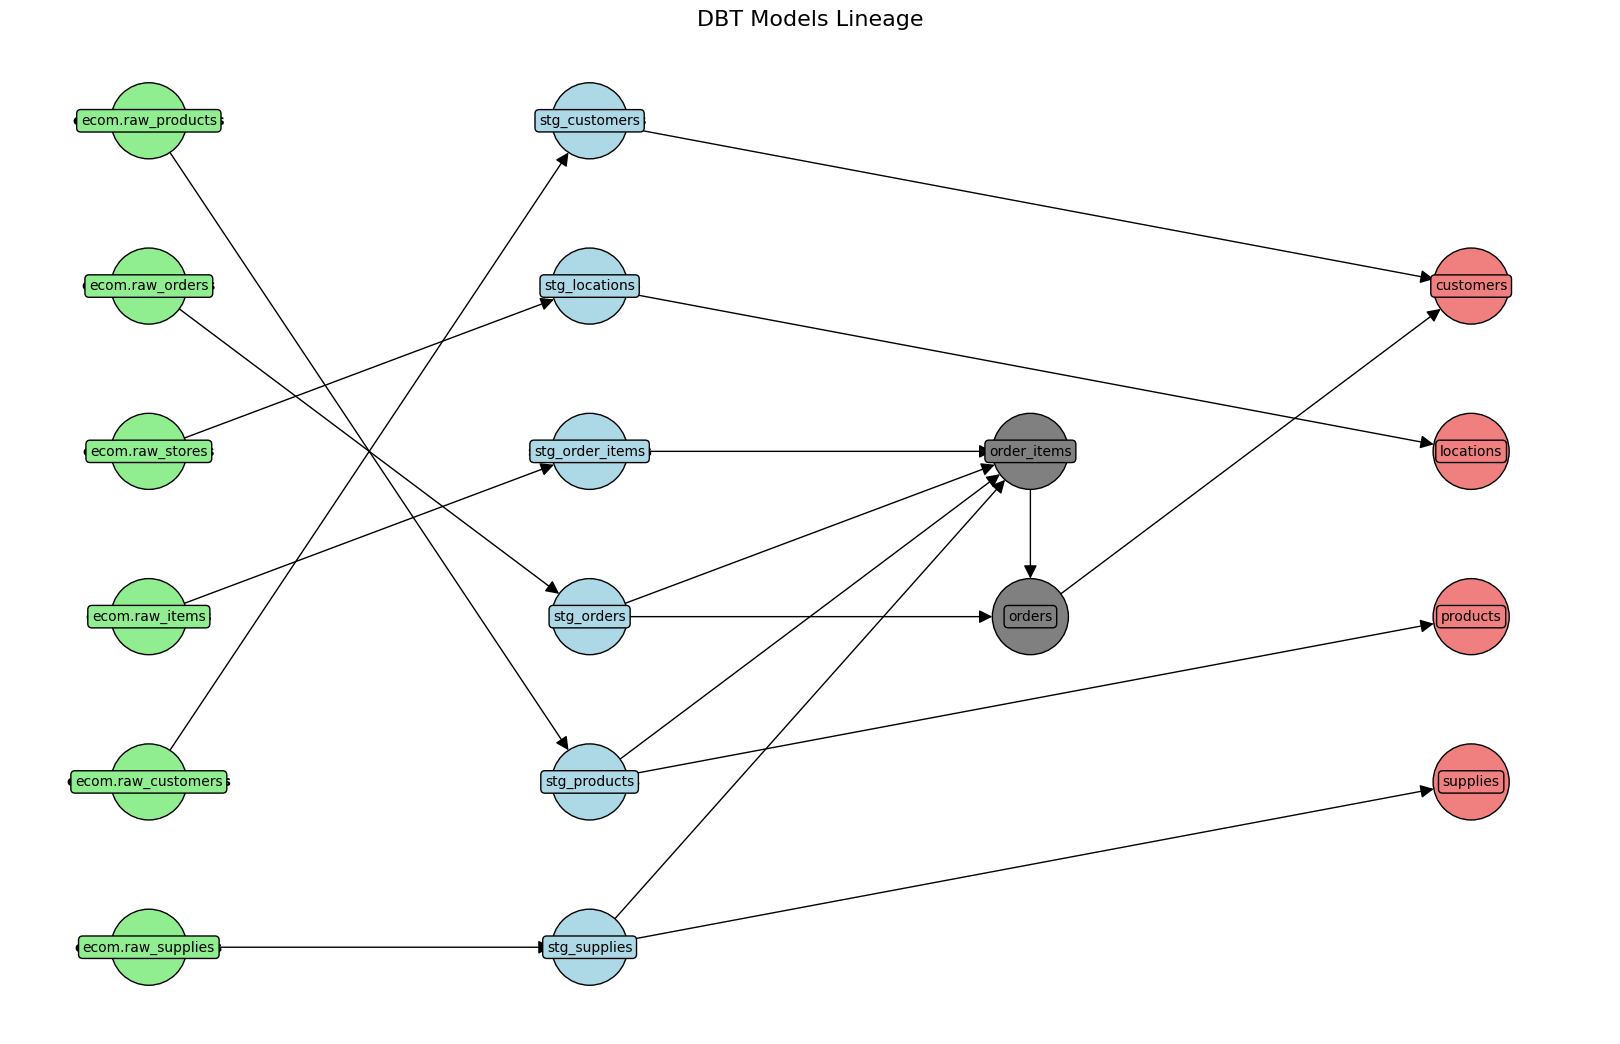

In [16]:
lineage_df = plot_dbt_lineage(dbt_repo_knowledge_df)

#### Test simple Retriever

In [17]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vectorstore = FAISS.from_documents(documents, embeddings)
print(vectorstore)

In [18]:
from langchain.chains import RetrievalQA, LLMChain, SequentialChain
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.schema.runnable import RunnableSequence

llm = ChatOpenAI(model=DEFAULT_LLM_MODEL, temperature=0.1, openai_api_key=OPENAI_API_KEY, openai_organization = OPENAI_ORGANIZATION)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [19]:
template = """
    You are a dbt expert. Based on the following context, answer the question concisely and accurately:
    {context}

    Question: {question}
"""
qa_prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_prompt},
)

In [20]:
query = "Que modelos se veran fectados si cambio el nombre de customer_id en stg_customers"
result = qa_chain.invoke({"query": query})

print(result["result"])
print(result["source_documents"])

Si cambias el nombre de `customer_id` en el modelo `stg_customers`, los siguientes modelos se verán afectados:

1. **Modelo de `customers`**: Este modelo utiliza `customer_id` para unirse con el resumen de pedidos (`customer_orders_summary`), por lo que el cambio afectará la lógica de unión y podría causar errores.

2. **Modelo de `customer_orders_summary`**: Aunque este modelo no tiene una referencia directa a `customer_id`, su lógica de agregación se basa en la relación con el modelo `orders`, que a su vez se une a `stg_customers` a través de `customer_id`.

Cualquier modelo que dependa de `stg_customers` y utilice `customer_id` también se verá afectado, por lo que es importante revisar todas las referencias a este campo en el proyecto.
[Document(id='f50f7851-7367-42b4-92a0-6a10d9f0e558', metadata={'knowledge_type': 'project', 'name': 'raw_orders.csv', 'path': 'jaffle-data/raw_orders.csv', 'source': None, 'parents': None, 'children': None, 'config': None, 'materialized': None, 'is_sn

#### Test BM25 Retriever

In [55]:
documents = list(vectorstore.docstore._dict.values())

In [56]:
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_documents = text_splitter.split_documents(documents)

Created a chunk of size 1278, which is longer than the specified 1000
Created a chunk of size 3322, which is longer than the specified 1000
Created a chunk of size 4987, which is longer than the specified 1000
Created a chunk of size 1389, which is longer than the specified 1000
Created a chunk of size 4774, which is longer than the specified 1000


In [ ]:
from langchain.retrievers import BM25Retriever
from langchain.schema import BaseRetriever, Document

from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from pydantic import Field, BaseModel
from typing import List
from rank_bm25 import BM25Okapi

In [58]:
class CustomBM25Retriever(BaseRetriever):
    bm25: BM25Okapi
    documents: List[Document]

    def __init__(self, bm25: BM25Okapi, documents: List[Document]):
        super().__init__(bm25=bm25, documents=documents)
        self.bm25 = bm25
        self.documents = documents

    def get_relevant_documents(self, query: str, k: int = 5) -> List[Document]:
        tokenized_query = word_tokenize(query.lower())
        scores = self.bm25.get_scores(tokenized_query)
        top_k_indices = np.argsort(scores)[::-1][:k]
        return [self.documents[i] for i in top_k_indices]

    async def aget_relevant_documents(self, query: str, k: int = 5) -> List[Document]:
        return self.get_relevant_documents(query, k)

retriever = CustomBM25Retriever(bm25=bm25, documents=split_documents)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_59813/483772869.py:1: DeprecationWarning: Retrievers must implement abstract `_get_relevant_documents` method instead of `get_relevant_documents`
  class CustomBM25Retriever(BaseRetriever):
/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_59813/483772869.py:1: DeprecationWarning: Retrievers must implement abstract `_aget_relevant_documents` method instead of `aget_relevant_documents`
  class CustomBM25Retriever(BaseRetriever):


In [59]:
retriever

CustomBM25Retriever(bm25=<rank_bm25.BM25Okapi object at 0x143d8e100>, documents=[Document(metadata={'knowledge_type': 'models', 'name': 'stg_customers.sql', 'path': 'models/staging/stg_customers.sql', 'source': "['ecom.raw_customers']", 'parents': '[]', 'children': "['customers']", 'config': nan, 'materialized': nan, 'is_snapshot': False, 'model_category': 'stg', 'vertical': 'customers', 'has_tests': True, 'has_select_all_in_last_select': True, 'has_group_by': False, 'is_filtered': False, 'is_source_model': True, 'is_seed': None, 'is_end_model': False, 'is_macro': None, 'is_test': None, 'macros': nan, 'packages': None}, page_content="Code:\n        WITH SOURCE AS\n  (SELECT *\n   FROM {{ source('ecom', 'raw_customers') }}), renamed AS\n  (SELECT ----------  ids\n id AS customer_id, ---------- text\n name AS customer_name\n   FROM SOURCE)\nSELECT *\nFROM renamed\n\n        Primary Key:\n        customer_id\n\n        IDS:\n        ['customer_id']\n\n        Columns used to Filter the mo

#### Agent test

In [60]:
# Retrieval Tool
retrieval_tool = Tool(
    name="Retrieve Info",
    func=lambda query: retriever.get_relevant_documents(query),
    description="Retrieve relevant context from the knowledge base.",
)

# Task Execution Prompt
task_prompt = PromptTemplate(
    template="""
        You are a dbt expert. Based on the context provided, perform the task below step-by-step:
        
        Task: {question}
        Context: {context}
    """,
    input_variables=["context", "question"],
)

# QA Chain for Task Execution
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": task_prompt},
)

# Task Execution Tool
task_tool = Tool(
    name="DBT Task Executor",
    func=lambda query: qa_chain.invoke({"query": query}),
    description="Execute dbt-related tasks like adding columns, creating models, or verifying dependencies.",
)

# Agent Configuration
tools = [retrieval_tool, task_tool]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
)

In [61]:
# Example Query
query = "Add a new column 'customer_age' to the 'stg_customers' model. The new column is available in the customer sources"

# Run the Agent
result = agent.run(query)
print("Agent Output:", result)



> Entering new AgentExecutor chain...
I need to add a new column 'customer_age' to the 'stg_customers' model. This requires executing a dbt task to modify the model and include the new column from the customer sources. 

Action: DBT Task Executor  
Action Input: Add column 'customer_age' to 'stg_customers' model using data from customer sources.  
Observation: {'query': "Add column 'customer_age' to 'stg_customers' model using data from customer sources.", 'result': "To add the column `customer_age` to the `stg_customers` model using data from customer sources, we will follow these steps:\n\n### Step 1: Identify the Source of `customer_age`\nFirst, we need to determine where the `customer_age` data is coming from. Assuming that the `raw_customers` table contains a column for `customer_age`, we will include it in our model.\n\n### Step 2: Modify the SQL Code\nWe will modify the existing SQL code in the `stg_customers` model to include the `customer_age` column. This involves selecting

#### Start complete chain

In [23]:
llm = ChatOpenAI(model=DEFAULT_LLM_MODEL, temperature=0.1, openai_api_key=OPENAI_API_KEY, openai_organization = OPENAI_ORGANIZATION)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [24]:
def gather_upstream(lineage_df, model_name):
    visited = set()
    frontier = [model_name]
    while frontier:
        current = frontier.pop()
        row = lineage_df[lineage_df["model_name"] == current]
        if not row.empty:
            for source in row["source"].iloc[0]:
                if source not in visited:
                    visited.add(source)
                    frontier.append(source)
            for parent in row["parent_models"].iloc[0]:
                if parent not in visited:
                    visited.add(parent)
                    frontier.append(parent)
    return sorted(visited)

def gather_downstream(lineage_df, model_name):
    visited = set()
    frontier = [model_name]
    while frontier:
        current = frontier.pop()
        row = lineage_df[lineage_df["model_name"] == current]
        if not row.empty:
            for child in row["children_models"].iloc[0]:
                if child not in visited:
                    visited.add(child)
                    frontier.append(child)
    return sorted(visited)

def get_affected_models(lineage_df, model_name):
    up = gather_upstream(lineage_df, model_name)
    down = gather_downstream(lineage_df, model_name)
    return {
        "upstream": list(up),
        "downstream": list(down),
    }

get_affected_models(lineage_df, 'order_items')

{'upstream': ['ecom.raw_items',
  'ecom.raw_orders',
  'ecom.raw_products',
  'ecom.raw_supplies',
  'stg_order_items',
  'stg_orders',
  'stg_products',
  'stg_supplies'],
 'downstream': ['customers', 'orders']}

In [64]:
import ast

def select_documents(documents, filtered_models):
    affected_dbt_models_documents = [
        doc for doc in documents
        if hasattr(doc, 'metadata') and doc.metadata.get("name") in filtered_models
    ]

    macro_names = set()
    for doc in affected_dbt_models_documents:
        macros = doc.metadata.get("macros", [])
        if isinstance(macros, str):
            macros = ast.literal_eval(macros)
        macro_names.update(f"{macro}.sql" for macro in macros if macro)

    unique_macros_list = list(macro_names)
    unique_macros_documents = [
        doc for doc in documents
        if hasattr(doc, 'metadata') and doc.metadata.get("name") in unique_macros_list
    ]

    retriever_documents = affected_dbt_models_documents + unique_macros_documents
    
    csv_sources_documents = [
        doc for doc in documents
        if hasattr(doc, 'metadata') and doc.metadata.get("knowledge_type") == "project" and doc.metadata.get("name")[-4:] == ".csv"
    ]

    yml_project_documents = [
        doc for doc in documents
        if hasattr(doc, 'metadata') and doc.metadata.get("knowledge_type") == "project" and doc.metadata.get("name")[-4:] == ".yml"
    ]

    return {
        "retriever_documents": retriever_documents,
        "csv_sources_documents": csv_sources_documents,
        "yml_project_documents": yml_project_documents
    }

In [65]:
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter

def create_bm25_retriever(documents, chunk_size=1000, chunk_overlap=100):
    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    split_documents = text_splitter.split_documents(documents)
    retriever = CustomBM25Retriever(bm25=bm25, documents=split_documents)
    return retriever

In [72]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

class Step:
    """Base class for a step in the processing pipeline."""
    def __init__(self, name):
        self.name = name

    def execute(self, input_data, context):
        raise NotImplementedError("Each step must implement the execute method.")

class InterpretationStep(Step):
    """Evaluate the user's request and decide the type of action needed."""
    def __init__(self, llm):
        super().__init__("Interpretation")
        self.llm = llm
        self.prompt_template = PromptTemplate(
            input_variables=["request"],
            template=("""
                <<>ROLE>>>
                You are an expert in interpreting user requests and translating them into clear and concise decisions and actions, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating problems into solutions.      

                <<<TASK>>>      
                Evaluate the request: {request}
                --------------------
                and based on the evaluation, determine the required action:
                1) adding a field -> return ADD_COLUMN
                2) modifying an existing model -> return MODIFY_MODEL
                3) retrieving and returning specific information. -> return RETRIVE_INFO
                
                Reflect on the request and provide a concise plan for the approach:
                - If the action involves adding a field: Identify where the field is currently available, if provided.
                - Determine how to propagate the field through the necessary models or transformations to integrate it into the target model.
                - Consider the impact on related models and dependencies.
                - If the action involves modifying an existing model: Identify the specific changes required.
                - Assess how these changes affect the structure, relationships, and downstream dependencies of the model.
                - If the action involves retrieving or returning information: Identify the models containing the relevant data.
                - Analyze how these models are related, and determine the queries or transformations needed to extract the requested information.
                      
                <<<OUPUT>>>
                Return the required action from the three proposed, and a short explanaition of the required work.
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required,  
                return only useful information, no additional filler text or unnecessary explanations, get to the point.
            """)   
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        prompt = self.prompt_template.format(request=input_data)
        interpretation = self.llm.invoke(prompt)
        context["interpretation"] = interpretation
        print(f"Step: {self.name} | Output: {interpretation}")
        return interpretation

class EvaluationStep(Step):
    """Evaluates on the user's request based on evaluation."""
    def __init__(self, llm):
        super().__init__("Evaluation")
        self.llm = llm
        self.prompt_template = PromptTemplate(
            input_variables=["request", "interpretation"],
            template=("""
                <<>ROLE>>>
                You are an expert in evaluating user requests and translating them into clear and concise decisions and actions, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating requests into solutions.      

                <<<TASK>>>      
                Based on the interpretation of an expert dbt and problem interpreter: {interpretation}
                --------------------
                of the original request
                ORIGINAL REQUEST: {request}
                --------------------
                Include only these topics if relevant:
                - Target models or files
                - Field existence
                - Documentation needs
                - Dependencies and relationships
                - Performance/design considerations
                - Tests
                - dbt project config
                - Code or logic generation
                
                Summarize only the necessary actions, no filler. Think about all the considerations and steps required to handle this request effectively.
                Your evaluation could include the following actions:
                - Identify the target model or models: Analyze the dependency tree to locate the model where the change should occur.
                - Understand its upstream sources (seeds, sources or base models)
                - Understand downstream dependencies of the model.
                - Documentation: Assess if it's going to be necessary to add adjustments to the documentation, and which would be this changes.
                - Unique keys and IDs: Examine the available unique keys and identifiers in the initial, intermediate, and final models.
                - Decide how these can be used to integrate the field or establish relationships between models.
                - Check if the granularity of the model can be altered through the changes added.
                - Evaluate performance and design: Review the data pipeline from start to finish.
                - Decide where the change or addition would be most optimal in terms of performance, data modeling, and maintainability.
                - Project state and impact: Consider the current state of the dbt project and how the changes might affect the broader model chain.
                - Macros and seeds: Check if relevant macros or seed data exist that can help transform or derive the required field or model.
                - Tests: Identify existing tests for the field or model and determine whether new tests need to be added or adjusted to validate the changes.
                - dbt project configuration: Review the general configuration (e.g., variables, environments, conventions) in the dbt_project.yml file to ensure the changes align with project standards and won't disrupt the schema.
                - Code generation: fragments of SQL logic needed, including CTEs or columns.
                - Evaluate whether an intermediate model is necessary or if the logic can be handled within the existing pipeline.
                - Documentation generation: Specify the documentation needed for any fields, models, or logic added or updated as part of this request. Only the things to add or change.
                
                <<<OUPUT>>>
                Provide a concise summary of the high-level tasks based on your analysis, with the reflection of each one of them to be prepared to completed in the next steps when context is provided. If you don't have the info to perform the action because it's necessary context of the project, code or the lineage of the models, don't answer it, in next steps context will be provide as input to answer it properly. Mark it as it's necessart the context to responde it, and only do the reflection part using your logic as dbt expert.
                No extra checks or steps that are not on this list, select only the needed actions for the request.
                Return only useful information, no additional filler text or unnecessary explanations, get to the point.
                      
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required.
            """)
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        interpretation = context.get("interpretation", "")
        prompt = self.prompt_template.format(request=input_data, interpretation=interpretation)
        evaluation = self.llm.invoke(prompt)
        context["evaluation"] = evaluation
        print(f"Step: {self.name} | Output: {evaluation}")
        return evaluation

from pydantic import BaseModel, Field
from typing import Literal
from langchain.output_parsers import PydanticOutputParser

class LineageResponse(BaseModel):
    model: str
    scope: Literal['UP', 'DOWN', 'ALL']

class LineageStep(Step):
    """Identify which models or documents should be consulted or modified using dbt lineage."""
    def __init__(self, llm, vectorstore):
        super().__init__("Lineage")
        self.llm = llm
        self.vectorstore = vectorstore

        self.parser = PydanticOutputParser(pydantic_object=LineageResponse)
        self.prompt_template = PromptTemplate(
            input_variables=["evaluation", "retrieved_context"],
            template=("""
                <<>ROLE>>>
                You are an expert in identifying the models and changes needed in a dbt repo given a request, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating requests into solutions, and using context and context information from the repository code and other models.

                <<<TASK>>>      
                Based on this evaluation: {evaluation}
                --------------------
                and the retrieved context, remember the meaning of all the context data:
                CONTEXT INFO AND METADATA MEANING:
                - knowledge_type: Specifies whether the resource is about files within the dbt project configuration, or data models used in the pipeline.
                - name: Name of the file.
                - path: Path within the repository where the file or resource is located, relative to the project root.
                - source: The original dataset, from which the model or resource pulls its data. Only for the first layer of the model.
                - parents: dbt models  that serve as input dependencies for the current model or file.
                - children: dbt models that depend on this resource as an input for their logic or data processing.
                - config: Configuration parameters defined in the file, specifying behaviors, sort keys, materialization...
                - materialized: Indicates how the data model is materialized (e.g., as a table, view, or ephemeral model) in the pipeline.
                - is_snapshot: Boolean flag that identifies whether the file represents a snapshot dbt model.
                - model_category: The logical dbt categorization of the model inside the project, such as base, staging, intermediate, marts...
                - vertical: Business domain or vertical to which the resource belongs, such as e-commerce, finance, supply...
                - has_tests: Boolean flag indicating if there are tests associated with this resource in the model .yaml file or in the tests folder.
                - has_select_all_in_last_select: Specifies if the final SQL query in the file uses a SELECT * statement. So all columns of previous CTEs will be consider as output of the model.
                - has_group_by: Boolean flag indicating if the SQL code includes a GROUP BY clause for aggregating data.
                - is_filtered: Boolean flag that specifies whether the resource applies filters to its data with WHERE, HAVING, JOIN...
                - is_source_model: The model uses the source macro to extract the data from the dbt project sources. It belongs to the first layer of all dbt models.
                - is_seed: Specifies if the resource is a seed file.
                - is_end_model: Boolean flag identifying if this is a terminal model in the data pipeline, representing the final output.
                - is_macro: Boolean flag indicating if the file defines a macro, used for reusable logic across the project. It does not count macros ref to call other models or source to connect to sources.
                - is_test: Indicates whether the file is a test sql definition used for testing purposes of other dbt models.
                - macros: Name of the macros used in the dbt model if any. It does not count macros ref to call other models or source to connect to sources.
                - packages: List of external packages or dependencies required for the resource or project functionality. Only not None in the packages.yml	row.

                      
                RETRIEVED CONTEXT: {retrieved_context}
                --------------------
                Determine:
                - The primary dbt model directly affected (e.g., where a field is added, a modification is made, or information is requested).
                - Whether upstream models (UP), downstream models (DOWN), or both (ALL) are necessary to handle this request correctly.
                
                Consider the following cases:
                1. If a new field is added, specify the model where the field will be added and indicate UP for upstream models needed to populate the field.
                2. If an existing field is modified, specify the model where the change occurs and indicate DOWN for downstream models affected by the change.
                3. If information is requested, specify the model containing the requested information and indicate UP, DOWN, or ALL based on the context of the data needed.
                4. If a field or model is removed, specify the model being affected and indicate DOWN for downstream dependencies impacted.
                      
                <<<OUPUT>>>
                Return the following json format: {{'model':model name, 'scope':UP/DOWN/ALL}}
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required.
            """)
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        evaluation = context.get("evaluation", "")
        
        all_documents_data = self.vectorstore.get()
        documents = [
            Document(page_content=content, metadata=metadata)
            for content, metadata in zip(all_documents_data["documents"], all_documents_data["metadatas"])
        ]
        bm25_retriever = create_bm25_retriever(documents)
        retrieved_documents = bm25_retriever.get_relevant_documents(input_data)

        retrieved_context = "\n".join([doc.page_content for doc in retrieved_documents if hasattr(doc, 'page_content')])
        context["documents_for_lineage"] = retrieved_documents
        print(f"Step: {self.name} | Retrieved Context: {retrieved_context}")

        prompt = self.prompt_template.format(evaluation=evaluation, retrieved_context=retrieved_context)

        response = self.llm.invoke(prompt)
        lineage_analysis_raw = response.dict()
        content = lineage_analysis_raw.get("content", "")

        json_string = content.replace("```json", "").replace("```", "").strip()
        lineage_analysis = eval(json_string)  # Use eval cautiously; use json.loads if the string is valid JSON
        
        context["lineage_analysis"] = lineage_analysis
        print(f"Step: {self.name} | Output: {lineage_analysis}")

        # ADD DOC FILTERING
        model_name = lineage_analysis.get("model")
        scope = lineage_analysis.get("scope", "").upper()

        affected_models = get_affected_models(lineage_df, model_name)
        if scope == "UP":
            filtered_models = affected_models["upstream"]
        elif scope == "DOWN":
            filtered_models = affected_models["downstream"]
        elif scope == "ALL":
            filtered_models = affected_models["upstream"] + affected_models["downstream"]

        filtered_models = list(set(f"{model}.sql" for model in filtered_models + [model_name]))

        all_documents_data = self.vectorstore.get()
        all_documents = [
            Document(page_content=content, metadata=metadata)
            for content, metadata in zip(all_documents_data["documents"], all_documents_data["metadatas"])
        ]
        
        selected_documents = select_documents(all_documents, filtered_models)
        context["selected_documents"] = selected_documents
        print(f"Step: {self.name} | Filtered Models: {filtered_models} | Filtered Documents: {len(selected_documents)}")
        return response

class PlanStep(Step):
    """Plan the steps needed based on evaluation and retrieved context."""
    def __init__(self, llm, embedding_function):
        super().__init__("Plan")
        self.llm = llm
        self.embedding_function = embedding_function

        self.prompt_template = PromptTemplate(
            input_variables=["evaluation", "retrieved_context", "lineage_analysis","retrieved_csv_sources_context"],
            template=("""
                <<>ROLE>>>
                You are an expert in planning and deciding the necessary changes in the affected models of a dbt project given a request, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating requests into solutions, and using context and context information from the repository code and other models.      

                <<<TASK>>>      
                Based on this evaluation: {evaluation}
                The analysis of the most impacted model and the part of the lineage that is affected or has related info 
                (UP = Upstream models(parent models)/DOWN = Downstream models(childen models)/ALL = both): 
                {lineage_analysis}
                --------------------
                the retrieved context, remember the meaning of all the context data:
                CONTEXT INFO AND METADATA MEANING:
                - knowledge_type: Specifies whether the resource is about files within the dbt project configuration, or data models used in the pipeline.
                - name: Name of the file.
                - path: Path within the repository where the file or resource is located, relative to the project root.
                - source: The original dataset, from which the model or resource pulls its data. Only for the first layer of the model.
                - parents: dbt models  that serve as input dependencies for the current model or file.
                - children: dbt models that depend on this resource as an input for their logic or data processing.
                - config: Configuration parameters defined in the file, specifying behaviors, sort keys, materialization...
                - materialized: Indicates how the data model is materialized (e.g., as a table, view, or ephemeral model) in the pipeline.
                - is_snapshot: Boolean flag that identifies whether the file represents a snapshot dbt model.
                - model_category: The logical dbt categorization of the model inside the project, such as base, staging, intermediate, marts...
                - vertical: Business domain or vertical to which the resource belongs, such as e-commerce, finance, supply...
                - has_tests: Boolean flag indicating if there are tests associated with this resource in the model .yaml file or in the tests folder.
                - has_select_all_in_last_select: Specifies if the final SQL query in the file uses a SELECT * statement. So all columns of previous CTEs will be consider as output of the model.
                - has_group_by: Boolean flag indicating if the SQL code includes a GROUP BY clause for aggregating data.
                - is_filtered: Boolean flag that specifies whether the resource applies filters to its data with WHERE, HAVING, JOIN...
                - is_source_model: The model uses the source macro to extract the data from the dbt project sources. It belongs to the first layer of all dbt models.
                - is_seed: Specifies if the resource is a seed file.
                - is_end_model: Boolean flag identifying if this is a terminal model in the data pipeline, representing the final output.
                - is_macro: Boolean flag indicating if the file defines a macro, used for reusable logic across the project. It does not count macros ref to call other models or source to connect to sources.
                - is_test: Indicates whether the file is a test sql definition used for testing purposes of other dbt models.
                - macros: Name of the macros used in the dbt model if any. It does not count macros ref to call other models or source to connect to sources.
                - packages: List of external packages or dependencies required for the resource or project functionality. Only not None in the packages.yml	row.

                RETRIEVED CONTEXT: {retrieved_context}
                --------------------
                and the examples about the some of the sources and the seeds (if any):

                {retrieved_csv_sources_context}
                --------------------
                Create a detailed step-by-step plan of the changes required in the existing models or files within the repository.
                To implement the requested change accurately.
                1. Ensure that you only refer to files, models, or fields that are explicitly mentioned in the retrieved information.
                2. Do not invent new models, fields, or dependencies. 
                3. Focus on:
                  - Identifying the exact files or models that need modifications, based on the retrieved context.
                  - Specifying what changes should be made, such as adding fields, updating logic, or modifying relationships.
                  - Highlighting any dependencies between models or files and describing how these should be handled.
                  - Extract children or parent models affected.
                  - If code fragments are provided in the retrieved context, incorporate them where applicable and explain their role.
                  - If no specific code or file is mentioned in the retrieved information, state that no changes should be made to existing files.
                  - Ensure the changes align with the dbt project's standards, such as conventions in `dbt_project.yml`, and do not introduce schema-breaking modifications.
                
                4. No extra checks or steps that are not on this list.
                5. Provide precise and actionable recommendations, avoiding any assumptions beyond the retrieved information.
                      
                <<<OUPUT>>>
                Return a summary of all the process, with the reflection, plan and context and the changes tht are neeeded to perfor
                      - The original request.
                      - The interpretarion of the request.
                      - The affected models with the info of the context and the lineage.
                      - All the necceasry changes step by step with a clear and short explanaiton of why is needed.
                Return only useful information, no additional filler text or unnecessary explanations, get to the point.
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required.
            """)
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        evaluation = context.get("evaluation", "")
        selected_documents = context.get("selected_documents")
        lineage_analysis = context.get("lineage_analysis")

        print(selected_documents)
        retriever_documents = selected_documents["retriever_documents"]
        csv_sources_documents = selected_documents["csv_sources_documents"]
        yml_project_documents = selected_documents["yml_project_documents"]

        # Create a new vectorstore with the filtered documents
        new_vectorstore = Chroma.from_documents(retriever_documents, self.embedding_function)

        # Return the response and the new retriever
        new_retriever = new_vectorstore.as_retriever()

        retrieved_documents = new_retriever.invoke(input_data)
        combined_documents =  yml_project_documents + retrieved_documents

        retrieved_context = "\n".join([doc.page_content for doc in combined_documents if hasattr(doc, 'page_content')])
        retrieved_csv_sources_context = "\n".join([doc.page_content for doc in csv_sources_documents if hasattr(doc, 'page_content')])

        context["documents_for_plan"] = combined_documents
        print(f"Step: {self.name} | Retrieved Context: {retrieved_context}")

        prompt = self.prompt_template.format(evaluation=evaluation, retrieved_context=retrieved_context, lineage_analysis=lineage_analysis, retrieved_csv_sources_context = retrieved_csv_sources_context)

        plan = self.llm.invoke(prompt)
        context["plan"] = plan
        print(f"Step: {self.name} | Output: {plan}")
        return plan

class ChatPipeline:
    """Manages the pipeline of steps."""
    def __init__(self, steps):
        self.steps = steps

    def execute(self, input_data):
        context = {}
        for step in self.steps:
            print(f"\nExecuting step: {step.name}")
            result = step.execute(input_data, context)
            print(f"Finished step: {step.name} | Result: {result}\n")
        return context

def main(user_input, llm, vectorstore, embeddings):
    # Define the steps
    steps = [
        InterpretationStep(llm),
        EvaluationStep(llm),
        LineageStep(llm, vectorstore),
        PlanStep(llm, embeddings),
    ]

    # Create the pipeline
    pipeline = ChatPipeline(steps)

    context = pipeline.execute(user_input)
    print("Context at the end of pipeline:", context)

    return context

In [67]:
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

loaded_vectorstore = Chroma(
    collection_name=COLLECTION_NAME,
    persist_directory=CHROMADB_DIRECTORY,
    embedding_function=embeddings
)

In [73]:
# Documents checks
vectorstore_data = loaded_vectorstore.get()
documents = vectorstore_data["documents"]
metadatas = vectorstore_data["metadatas"] 

filtered_documents = [
    {"document": doc, "metadata": meta}
    for doc, meta in zip(documents, metadatas)
    if meta.get("name") == "stg_orders.sql"
]

print(f"Documents: {len(filtered_documents)}")
for item in filtered_documents:
    print("Document:", item["document"])
    print("Metadata:", item["metadata"])

Documents: 1
Document: Code:
        WITH SOURCE AS
  (SELECT *
   FROM {{ source('ecom', 'raw_orders') }}), renamed AS
  (SELECT ----------  ids
 id AS order_id,
 store_id AS location_id,
 customer AS customer_id, ---------- numerics
 subtotal AS subtotal_cents,
 tax_paid AS tax_paid_cents,
 order_total AS order_total_cents, {{ cents_to_dollars('subtotal') }} AS subtotal, {{ cents_to_dollars('tax_paid') }} AS tax_paid, {{ cents_to_dollars('order_total') }} AS order_total, ---------- timestamps
 {{ dbt.date_trunc('day', 'ordered_at') }} AS ordered_at
   FROM SOURCE)
SELECT *
FROM renamed

        Primary Key:
        order_id

        IDS:
        ['location_id', 'store_id', 'customer_id', 'order_id']

        Columns used to Filter the model throuhg JOINS, HAVING, WHERE...:
        N/A

        Tests:
        {'columns': {'order_id': ['not_null', 'unique']}, 'unit_tests': []}

        YML Code:
        {'models': [{'name': 'stg_orders', 'description': 'Order data with basic cleaning a

In [ ]:
user_input = "what is the output model related with orders"
llm_results = main(user_input, llm, loaded_vectorstore, embeddings)


Executing step: Interpretation
Step: Interpretation | Input: what is the output model related with orders


In [35]:
Markdown(llm_results['plan'].content)

### Original Request
Implement changes to the `orders` model based on the evaluation provided.

### Interpretation of the Request
The request involves analyzing the `orders` model, understanding its dependencies, and determining necessary changes to improve its structure, performance, and documentation.

### Affected Models
- **Target Model**: `orders`
- **Upstream Models**: 
  - `stg_orders`
  - `order_items`
- **Downstream Models**: 
  - Models that depend on `orders` (not explicitly listed in the retrieved context).

### Necessary Changes Step-by-Step

1. **Identify Dependencies**:
   - Confirm that `orders` depends on `stg_orders` and `order_items`. Ensure these upstream models are functioning correctly.

2. **Review Upstream Sources**:
   - Check the definitions of `stg_orders` and `order_items` to ensure they provide the necessary data without issues.

3. **Assess Downstream Dependencies**:
   - Identify any downstream models that rely on `orders`. Ensure they are updated if changes to `orders` affect their logic.

4. **Documentation Updates**:
   - Update the documentation for the `orders` model to reflect any changes made, including descriptions of new fields or logic.

5. **Unique Keys and IDs**:
   - Ensure that the primary key (`order_id`) and identifiers (`order_item_id`, `customer_id`) are correctly defined and utilized in the model.

6. **Granularity Assessment**:
   - Evaluate if the granularity of the `orders` model can be adjusted. If necessary, modify the SQL logic to aggregate or disaggregate data appropriately.

7. **Performance Review**:
   - Analyze the SQL logic for performance. Consider optimizing joins or aggregations if they are causing slow performance.

8. **Check for Macros and Seeds**:
   - Review any macros or seed data that could enhance the `orders` model. Implement relevant macros if they simplify the logic.

9. **Testing**:
   - Ensure existing tests for the `orders` model are comprehensive. Add new tests if new fields or logic are introduced.

10. **dbt Project Configuration**:
    - Verify that changes align with the standards set in `dbt_project.yml`. Ensure materialization and configurations are consistent.

11. **SQL Logic Preparation**:
    - Prepare any SQL logic fragments needed for the `orders` model based on the changes identified.

12. **Intermediate Model Necessity**:
    - Determine if an intermediate model is required to simplify the logic in `orders`. If so, create it.

13. **Documentation Generation**:
    - Specify any additional documentation needed for changes made to the `orders` model.

### Summary
The changes to the `orders` model will involve reviewing dependencies, updating documentation, ensuring unique keys are utilized, assessing granularity, optimizing performance, and verifying tests. All modifications should align with the dbt project's standards and ensure that downstream models are not adversely affected.